In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras.backend as K
K.clear_session()

In [5]:
# Load appropriate packages
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions, preprocess_input    

In [109]:
#USING 100*100 BECAUSE MY COMPUTER IS HALFWAY DECENT
batch_size = 1000
nrow = 100
ncol = 100
nchan = 3
input_shape = (batch_size,nrow,ncol,nchan)
x = np.zeros(input_shape)
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(100,100,3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [113]:
model = Sequential()
for layer in base_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

In [114]:
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [80]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [81]:
test_data_dir = './test'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [46]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0


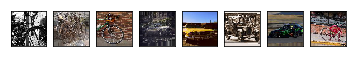

In [104]:
x,y = train_generator.next()
for i in range(0,8):
    plt.subplot(1,8,i+1)
    disp_image(x[i])
    print(y[i])
#bike = 0, car = 1

In [83]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])


In [84]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

In [86]:
nepochs = 5  # Number of epochs

# Call the fit function
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
62/62 [==============================] - 284s 5s/step - loss: 0.2943 - acc: 0.8679 - val_loss: 0.1668 - val_acc: 0.9427
Epoch 2/5
62/62 [==============================] - 345s 6s/step - loss: 0.1667 - acc: 0.9360 - val_loss: 0.1463 - val_acc: 0.9444
Epoch 3/5
62/62 [==============================] - 326s 5s/step - loss: 0.1595 - acc: 0.9415 - val_loss: 0.0844 - val_acc: 0.9757
Epoch 4/5
62/62 [==============================] - 337s 5s/step - loss: 0.1297 - acc: 0.9481 - val_loss: 0.1334 - val_acc: 0.9514
Epoch 5/5
62/62 [==============================] - 323s 5s/step - loss: 0.1515 - acc: 0.9415 - val_loss: 0.0808 - val_acc: 0.9705


[ 0.]
[ 0.]
[ 0.]
[ 0.]


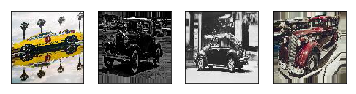

In [105]:
errors = 0
error_pics = []
error_vals = []
while errors < 4:
    x,y = train_generator.next()
    yhat = np.rint(model.predict(x))   
    for i in range(len(x)):
        if y[i] != yhat[i][0]:
            error_pics.append(x[i])
            error_vals.append(yhat[i])
            errors += 1
    
for i in range(4):
    plt.subplot(1,4,i+1)
    disp_image(error_pics[i])
    print(error_vals[i])